# Library Import

In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.Path().resolve().parent))

#-- Basics Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import joblib
from sklearn.preprocessing import MinMaxScaler


#-- Metrics Calculation
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_percentage_error as MAPE

#-- Warnings OFF
from warnings import simplefilter

from utils import *
from etuni import *


pd.set_option('display.max_columns', None)
simplefilter("ignore", FutureWarning)
np.seterr(all="ignore")
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['PYTHONHASHSEED']=str('123')

%matplotlib inline

2025-11-08 12:19:37.238902: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-08 12:19:42.952393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-08 12:19:50.628599: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


# Param definition

In [2]:
def model_performance(df_predicted):
    train = df_predicted[df_predicted.tipo == '1. train']
    validation = df_predicted[df_predicted.tipo == '2. validation']
    test = df_predicted[df_predicted.tipo == '3. test']

    metric_df_final = pd.DataFrame(
        {
        'sample': df_predicted['sample'].unique()[0],
        'tipo':['Treino','Validation','Teste'],
        'MSE': [MSE(train['real'],train['pred']), MSE(validation['real'],validation['pred']), MSE(test['real'],test['pred'])],
        'MAE': [MAE(train['real'],train['pred']), MAE(validation['real'],validation['pred']), MAE(test['real'],test['pred'])],
        'MAPE': [MAPE(train['real'],train['pred']), MAPE(validation['real'],validation['pred']), MAPE(test['real'],test['pred'])],
        'R2':  [R2(train['real'],train['pred']), R2(validation['real'],validation['pred']), R2(test['real'],test['pred'])],
        }
    )

    return metric_df_final

def model_performance_vec(df_predicted):

    mean_precition = df_predicted.groupby('date').agg({'sample':'mean','real':'mean','pred':['mean','std','min','max','count']})
    mean_precition.reset_index(inplace=True)
    mean_precition.columns = ['date','sample','real','mean','std','min','max','count']
    mean_precition['date'] = pd.to_datetime(mean_precition['date'])
    mean_precition['tipo'] = mean_precition['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))


    train = mean_precition[mean_precition.tipo == '1. train']
    validation = mean_precition[mean_precition.tipo == '2. validation']
    test = mean_precition[mean_precition.tipo == '3. test']

    metric_df_final = pd.DataFrame(
        {
        'sample': mean_precition['sample'].unique()[0],
        'tipo':['Treino','Validation','Teste'],
        'MSE': [MSE(train['real'],train['mean']), MSE(validation['real'],validation['mean']), MSE(test['real'],test['mean'])],
        'MAE': [MAE(train['real'],train['mean']), MAE(validation['real'],validation['mean']), MAE(test['real'],test['mean'])],
        'MAPE': [MAPE(train['real'],train['mean']), MAPE(validation['real'],validation['mean']), MAPE(test['real'],test['mean'])],
        'R2':  [R2(train['real'],train['mean']), R2(validation['real'],validation['mean']), R2(test['real'],test['mean'])],
        }
    )

    return metric_df_final

In [3]:
#-- Parameters
look_back = 12
num_month = 12
vec_num = 12

#-- Training and fitting
epochs=1000
batch_size= 120
deltaT = 1

FIGURE_PATH = '../Figure/Results/'

# Camargos

In [4]:
camargos_raw = pd.read_csv(f'../Datasets/Processed/Camargos.csv')
esc_camargos = escalar_etuni_build(camargos_raw,look_back,deltaT)
vec_camargos = vetorial_etuni_build(camargos_raw,look_back,vec_num,deltaT)


In [5]:
esc_camargos.head(10)

,date,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,pred_1,lag_etuni_12,lag_etuni_11,lag_etuni_10,lag_etuni_9,lag_etuni_8,lag_etuni_7,lag_etuni_6,lag_etuni_5,lag_etuni_4,lag_etuni_3,lag_etuni_2,lag_etuni_1,lag_etuni_0,cohort
0,1932-01-01,0.265683,0.621771,0.538745,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.265683,0.356089,-0.083026,0.282288,-0.271218,-0.195572,-0.186347,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,1. train
1,1932-02-01,0.621771,0.538745,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.621771,-0.083026,0.282288,-0.271218,-0.195572,-0.186347,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,-0.193727,1. train
2,1932-03-01,0.538745,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.538745,0.282288,-0.271218,-0.195572,-0.186347,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,-0.193727,-0.239852,1. train
3,1932-04-01,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.821033,-0.271218,-0.195572,-0.186347,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,-0.193727,-0.239852,-0.261993,1. train
4,1932-05-01,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.549815,-0.195572,-0.186347,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,-0.193727,-0.239852,-0.261993,-0.007380,1. train
5,1932-06-01,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.118081,0.354244,-0.186347,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,-0.193727,-0.239852,-0.261993,-0.007380,0.055351,1. train
6,1932-07-01,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.118081,0.086716,0.167897,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,-0.193727,-0.239852,-0.261993,-0.007380,0.055351,-0.031365,1. train
7,1932-08-01,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.118081,0.086716,0.068266,0.101476,0.042435,0.147601,-0.071956,0.114391,0.431734,-0.193727,-0.239852,-0.261993,-0.007380,0.055351,-0.031365,-0.018450,1. train
8,1932-09-01,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.118081,0.086716,0.068266,0.071956,0.143911,0.147601,-0.071956,0.114391,0.431734,-0.193727,-0.239852,-0.261993,-0.007380,0.055351,-0.031365,-0.018450,0.003690,1. train
9,1932-10-01,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.118081,0.086716,0.068266,0.071956,0.107011,0.291513,-0.071956,0.114391,0.431734,-0.193727,-0.239852,-0.261993,-0.007380,0.055351,-0.031365,-0.018450,0.003690,0.035055,1. train


In [6]:
vec_camargos[[x for x in vec_camargos.columns if 'lag_etuni' not in x]]

,date,lag_24,lag_23,lag_22,lag_21,lag_20,lag_19,lag_18,lag_17,lag_16,lag_15,lag_14,lag_13,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,start_date,end_date,cohort
0,1931-01-01,0.265683,0.621771,0.538745,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.118081,0.086716,0.068266,0.071956,0.107011,0.125461,0.380074,1932-01-01,1932-12-01,1. train
1,1931-02-01,0.621771,0.538745,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.118081,0.086716,0.068266,0.071956,0.107011,0.125461,0.380074,0.466790,1932-02-01,1933-01-01,1. train
2,1931-03-01,0.538745,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.118081,0.086716,0.068266,0.071956,0.107011,0.125461,0.380074,0.466790,0.234317,1932-03-01,1933-02-01,1. train
3,1931-04-01,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.118081,0.086716,0.068266,0.071956,0.107011,0.125461,0.380074,0.466790,0.234317,0.208487,1932-04-01,1933-03-01,1. train
4,1931-05-01,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.118081,0.086716,0.068266,0.071956,0.107011,0.125461,0.380074,0.466790,0.234317,0.208487,0.136531,1932-05-01,1933-04-01,1. train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,2010-09-01,0.040590,0.079336,0.267528,0.476015,0.905904,0.282288,0.374539,0.214022,0.160517,0.123616,0.090406,0.062731,0.049815,0.092251,0.108856,0.470480,0.642066,0.367159,0.217712,0.132841,0.136531,0.125461,0.081181,0.049815,2011-09-01,2012-08-01,3. test
957,2010-10-01,0.079336,0.267528,0.476015,0.905904,0.282288,0.374539,0.214022,0.160517,0.123616,0.090406,0.062731,0.049815,0.092251,0.108856,0.470480,0.642066,0.367159,0.217712,0.132841,0.136531,0.125461,0.081181,0.049815,0.033210,2011-10-01,2012-09-01,3. test
958,2010-11-01,0.267528,0.476015,0.905904,0.282288,0.374539,0.214022,0.160517,0.123616,0.090406,0.062731,0.049815,0.092251,0.108856,0.470480,0.642066,0.367159,0.217712,0.132841,0.136531,0.125461,0.081181,0.049815,0.033210,0.044280,2011-11-01,2012-10-01,3. test
959,2010-12-01,0.476015,0.905904,0.282288,0.374539,0.214022,0.160517,0.123616,0.090406,0.062731,0.049815,0.092251,0.108856,0.470480,0.642066,0.367159,0.217712,0.132841,0.136531,0.125461,0.081181,0.049815,0.033210,0.044280,0.107011,2011-12-01,2012-11-01,3. test


In [7]:
esc_camargos.groupby('cohort').agg(
    {'date':['min','max','count']
    }
)


date                 
                     min        max count
cohort                                   
1. train      1932-01-01 1997-11-01   791
2. validation 1997-12-01 2002-12-01    61
3. test       2003-01-01 2012-12-01   120

In [8]:
vec_camargos.groupby('cohort').agg(
    {'start_date':['min','max','count'],
     'end_date':['min','max','count']
    }
)


start_date                    end_date                 
                     min        max count        min        max count
cohort                                                               
1. train      1932-01-01 1996-12-01   780 1932-12-01 1997-11-01   780
2. validation 1997-01-01 2002-01-01    61 1997-12-01 2002-12-01    61
3. test       2002-02-01 2012-01-01   120 2003-01-01 2012-12-01   120

## Escalar 

In [9]:
esc_camargos.head()

,date,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,pred_1,lag_etuni_12,lag_etuni_11,lag_etuni_10,lag_etuni_9,lag_etuni_8,lag_etuni_7,lag_etuni_6,lag_etuni_5,lag_etuni_4,lag_etuni_3,lag_etuni_2,lag_etuni_1,lag_etuni_0,cohort
0,1932-01-01,0.265683,0.621771,0.538745,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.265683,0.356089,-0.083026,0.282288,-0.271218,-0.195572,-0.186347,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,1. train
1,1932-02-01,0.621771,0.538745,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.621771,-0.083026,0.282288,-0.271218,-0.195572,-0.186347,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,-0.193727,1. train
2,1932-03-01,0.538745,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.538745,0.282288,-0.271218,-0.195572,-0.186347,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,-0.193727,-0.239852,1. train
3,1932-04-01,0.821033,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.821033,-0.271218,-0.195572,-0.186347,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,-0.193727,-0.239852,-0.261993,1. train
4,1932-05-01,0.549815,0.354244,0.167897,0.101476,0.143911,0.291513,0.219557,0.333948,0.765683,0.571956,0.332103,0.070111,0.062731,0.549815,-0.195572,-0.186347,-0.066421,0.042435,0.147601,-0.071956,0.114391,0.431734,-0.193727,-0.239852,-0.261993,-0.007380,1. train


In [10]:
lag_list = [x for x in esc_camargos.columns if 'lag_etuni' in x]
pred_list = lag_list.pop()

In [11]:
esc_train = esc_camargos[esc_camargos['cohort'] == '1. train'].copy()
esc_validation = esc_camargos[esc_camargos['cohort'] == '2. validation'].copy()
esc_test = esc_camargos[esc_camargos['cohort'] == '3. test'].copy()

In [12]:
file_path = "../Results/Models/camargos_esc_weights_etuni_img.weights.h5"

# Definindo os callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    save_weights_only=True,
    # monitor='val_loss',
    # mode='min',
    monitor='val_r2',
    mode='max',
    save_best_only=True,
    verbose=0
)


In [13]:
model_esc = EtuniModel(look_back=12,vec_num=1)

callbacks_list = [
    model_checkpoint
    ]

history = model_esc.fit(
    esc_train[lag_list],
    esc_train[pred_list],
    # epochs=epochs,
    # batch_size=batch_size,
    epochs=epochs//2,
    batch_size=len(esc_train),
    
    verbose=1,
    validation_data=(esc_validation[lag_list], esc_validation[pred_list]),
    # callbacks=callbacks_list,
    shuffle=True
)


2025-11-08 12:19:57.051236: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0156 - mae: 0.0833 - mape: 185128.8750 - mse: 0.0156 - val_loss: 0.0068 - val_mae: 0.0600 - val_mape: 30117.1895 - val_mse: 0.0068
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0155 - mae: 0.0821 - mape: 131690.4844 - mse: 0.0155 - val_loss: 0.0067 - val_mae: 0.0590 - val_mape: 13818.8330 - val_mse: 0.0067
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0154 - mae: 0.0811 - mape: 88047.6562 - mse: 0.0154 - val_loss: 0.0067 - val_mae: 0.0582 - val_mape: 39024.7734 - val_mse: 0.0067
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0153 - mae: 0.0804 - mape: 69941.0312 - mse: 0.0153 - val_loss: 0.0067 - val_mae: 0.0576 - val_mape: 52276.3438 - val_mse: 0.0067
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0152 - mae: 0.0798 - mape: 62961.9688 - mse: 0.0152 - val_loss: 0.0066 - val_mae: 0.0571 - val_mape: 63117.6133 - val_mse: 0.0066
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 

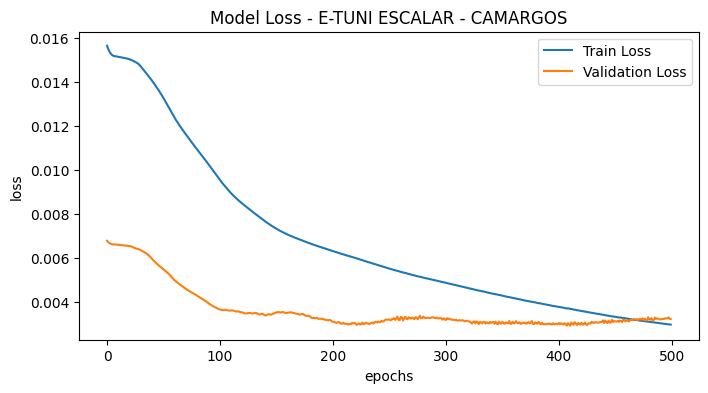

In [14]:
# Plot and save loss function from model history

method_name = 'E-TUNI ESCALAR - CAMARGOS'
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss - {method_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(f'{FIGURE_PATH}/model_loss_{method_name}.png', format='png')
plt.show()



In [15]:
model_esc_camargos = EtuniModel(look_back=12, vec_num=1)
model_esc_camargos.load_weights(file_path)
camargos_scaler = joblib.load('../Results/Models/Camargos_scaler.pkl')
df_escalar = esc_camargos[['date','pred_1']].copy()
df_escalar.columns = ['date','real_norm']
df_escalar['real'] = camargos_scaler.inverse_transform(df_escalar[['real_norm']])

dataset_compilation = esc_camargos[lag_list].copy()
dataset_compilation[pred_list] = model_esc.predict(esc_camargos[lag_list])

df_result_esc = decode_etuni_escalar(dataset_compilation,look_back,deltaT)
df_escalar['pred_norm'] = df_result_esc[pred_list]
df_escalar['pred'] = camargos_scaler.inverse_transform(df_escalar[['pred_norm']])

df_escalar['tipo'] = df_escalar['date'].apply(lambda x: cohort_type(x,model_type='escalar'))

df_escalar.to_csv('../Results/E-TUNI/Camargos/Escalar/etuni_camargos_pred_2025_10_15.csv', index=False)

df_escalar


/home/thiago-lopes/anaconda3/envs/e-tuni-ita/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,date,real_norm,real,pred_norm,pred,tipo
0,1932-01-01,0.765683,449.0,0.748149,439.496921,1. train
1,1932-02-01,0.571956,344.0,0.589269,353.383710,1. train
2,1932-03-01,0.332103,214.0,0.299326,196.234747,1. train
3,1932-04-01,0.070111,72.0,0.082592,78.764802,1. train
4,1932-05-01,0.062731,68.0,0.065337,69.412877,1. train
...,...,...,...,...,...,...
967,2012-08-01,0.049815,61.0,0.076931,75.696449,3. test
968,2012-09-01,0.033210,52.0,0.054245,63.400525,3. test
969,2012-10-01,0.044280,58.0,0.105370,91.110658,3. test
970,2012-11-01,0.107011,92.0,0.083944,79.497420,3. test


In [16]:
train = df_escalar[df_escalar.tipo == '1. train']
validation = df_escalar[df_escalar.tipo == '2. validation']
test = df_escalar[df_escalar.tipo == '3. test']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Validation','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(validation['real'],validation['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(validation['real'],validation['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(validation['real'],validation['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(validation['real'],validation['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('../Results/E-TUNI/Camargos/Escalar/etuni_camargos_results_2025_10_15.csv' , index=False)

,tipo,MSE,MAE,MAPE,R2
0,Treino,875.538712,19.664726,0.156747,0.877890
1,Validation,952.744855,22.711019,0.231174,0.737800
2,Teste,4254.627457,41.033483,0.297599,0.383884


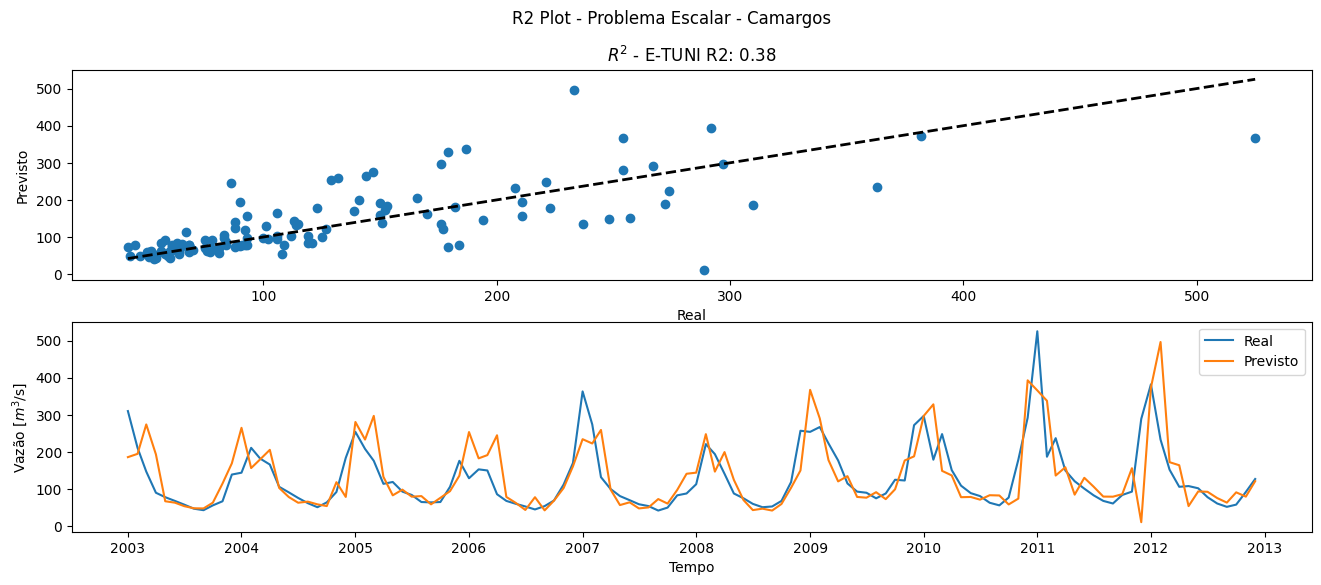

In [17]:
figure, axes = plt.subplots(2, 1, figsize=(16,6))
figure.suptitle(f'R2 Plot - Problema Escalar - Camargos')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - E-TUNI R2: {r2_result:.2f}') #r2_result:.3f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Real')
axes[0].set_ylabel('Previsto')

sns.lineplot(ax = axes[1], data=test,x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=test,x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'../Figure/Results/etuni_esc_camargos_r2_2025_10_15.png', format='png')

plt.show()

In [18]:
sample = 100

# metrics_list = []
# for i in range(sample):
#     model_temp = EtuniModel(look_back=12,vec_num=1)

#     file_path = f"../Results/Models/camargos_esc_weights_etuni_sample_{i}.weights.h5"

#     model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#         filepath=file_path,
#         save_weights_only=True,
#         monitor='val_loss',
#         mode='min',
#         save_best_only=True,
#         verbose=0
#     )

#     model_temp.fit(
#         esc_train[lag_list],
#         esc_train[pred_list],
#         epochs=epochs//2,
#         # batch_size=batch_size,
#         batch_size=len(esc_train),
#         verbose=0,
#         validation_data=(esc_validation[lag_list], esc_validation[pred_list]),
#         # callbacks=[model_checkpoint],
#         shuffle=True
#     )

#     # model_esc_camargos = EtuniModel(look_back=12, vec_num=1)
#     # model_esc_camargos.load_weights(file_path)

#     # model_esc_camargos = model_temp
#     camargos_scaler = joblib.load('../Results/Models/Camargos_scaler.pkl')
#     df_escalar = esc_camargos[['date','pred_1']].copy()
#     df_escalar.columns = ['date','real_norm']
#     df_escalar['real'] = camargos_scaler.inverse_transform(df_escalar[['real_norm']])
    
#     dataset_compilation = esc_camargos[lag_list].copy()
#     dataset_compilation[pred_list] = model_temp.predict(esc_camargos[lag_list])
#     df_result_esc = decode_etuni_escalar(dataset_compilation,look_back,deltaT)
#     df_escalar['pred_norm'] = df_result_esc[pred_list]
#     df_escalar['pred'] = camargos_scaler.inverse_transform(df_escalar[['pred_norm']])
#     df_escalar['tipo'] = df_escalar['date'].apply(lambda x: cohort_type(x,model_type='escalar'))
#     df_escalar['sample'] = i
#     print(i)

#     del model_temp

#     df_escalar.to_csv(f'../Results/E-TUNI/Camargos/Escalar/Samples/etuni_camargos_pred_sample_{i}.csv', index=False)





In [19]:
def model_performance(df_predicted):
    train = df_predicted[df_predicted.tipo == '1. train']
    validation = df_predicted[df_predicted.tipo == '2. validation']
    test = df_predicted[df_predicted.tipo == '3. test']

    metric_df_final = pd.DataFrame(
        {
        'sample': df_predicted['sample'].unique()[0],
        'tipo':['Treino','Validation','Teste'],
        'MSE': [MSE(train['real'],train['pred']), MSE(validation['real'],validation['pred']), MSE(test['real'],test['pred'])],
        'MAE': [MAE(train['real'],train['pred']), MAE(validation['real'],validation['pred']), MAE(test['real'],test['pred'])],
        'MAPE': [MAPE(train['real'],train['pred']), MAPE(validation['real'],validation['pred']), MAPE(test['real'],test['pred'])],
        'R2':  [R2(train['real'],train['pred']), R2(validation['real'],validation['pred']), R2(test['real'],test['pred'])],
        }
    )

    return metric_df_final



In [20]:

all_results = pd.concat([model_performance(pd.read_csv(f'../Results/E-TUNI/Camargos/Escalar/Samples/etuni_camargos_pred_sample_{i}.csv')) for i in range(sample)]).reset_index(drop=True)
all_results.to_csv(f'../Results/E-TUNI/Camargos/Escalar/Samples/all_results.csv', index=False)
all_results

,sample,tipo,MSE,MAE,MAPE,R2
0,0,Treino,877.742510,18.794974,0.149180,0.877583
1,0,Validation,1521.683566,27.046250,0.262192,0.581225
2,0,Teste,2552.268299,34.408239,0.250448,0.630404
3,1,Treino,1290.009289,22.839265,0.172737,0.820084
4,1,Validation,880.638864,20.327101,0.208838,0.757644
...,...,...,...,...,...,...
295,98,Validation,1161.881035,23.233722,0.226017,0.680245
296,98,Teste,4269.833928,39.838203,0.296355,0.381682
297,99,Treino,1061.710583,20.724794,0.164773,0.851925
298,99,Validation,1843.963755,27.774924,0.283804,0.492532


## Vetorial

In [21]:
all_list = [x for x in vec_camargos.columns if 'lag_etuni_' in x]

lag_list = []
pred_list = []

for col in all_list:
    num = int(col.split('lag_etuni_')[1])
    if num > 12:
        lag_list.append(col)
    else:
        pred_list.append(col)

len(all_list)

24

In [22]:
vec_train = vec_camargos[vec_camargos['cohort'] == '1. train'].copy()
vec_validation = vec_camargos[vec_camargos['cohort'] == '2. validation'].copy()
vec_test = vec_camargos[vec_camargos['cohort'] == '3. test'].copy()

# only_one_year = [str(x) +'-01-01' for x in range(1932,2012 + 1,1)]
# reduced_vec_camargos = vec_camargos[vec_camargos['date'].isin(only_one_year)]
# vec_train = reduced_vec_camargos[reduced_vec_camargos['cohort'] == '1. train'].copy()
# vec_validation = reduced_vec_camargos[reduced_vec_camargos['cohort'] == '2. validation'].copy()
# vec_test = reduced_vec_camargos[reduced_vec_camargos['cohort'] == '3. test'].copy()

In [23]:
print(vec_train.shape)
print(vec_validation.shape)
print(vec_test.shape)


(780, 52)
(61, 52)
(120, 52)


In [24]:
model_vec = EtuniModel(look_back=12,vec_num=12)
file_path = f"../Results/Models/camargos_vec_weights_etuni_img.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    save_weights_only=True,
    # monitor='val_loss',
    # mode='min',
    monitor='val_r2',
    mode='max',
    save_best_only=True,
    verbose=0
)

history = model_vec.fit(
    vec_train[lag_list],
    vec_train[pred_list],
    epochs=epochs//2,
    # batch_size=batch_size,
    batch_size=len(vec_train),
    verbose=1,
    validation_data=(vec_validation[lag_list], vec_validation[pred_list]),
    # callbacks=[model_checkpoint],
    shuffle=True
)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0150 - mae: 0.0800 - mape: 174193.4844 - mse: 0.0150 - val_loss: 0.0070 - val_mae: 0.0583 - val_mape: 282068.6250 - val_mse: 0.0070
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0150 - mae: 0.0797 - mape: 147332.9062 - mse: 0.0150 - val_loss: 0.0069 - val_mae: 0.0581 - val_mape: 246025.6562 - val_mse: 0.0069
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0150 - mae: 0.0795 - mape: 129153.2109 - mse: 0.0150 - val_loss: 0.0069 - val_mae: 0.0579 - val_mape: 217826.0000 - val_mse: 0.0069
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0149 - mae: 0.0793 - mape: 116859.2500 - mse: 0.0149 - val_loss: 0.0069 - val_mae: 0.0578 - val_mape: 195164.0469 - val_mse: 0.0069
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0149 - mae: 0.0792 - mape: 111683.5156 - mse: 0.0149 - val_loss: 0.0069 - val_mae: 0.0578 - val_mape: 192701.7656 - val_mse: 0.0069
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67

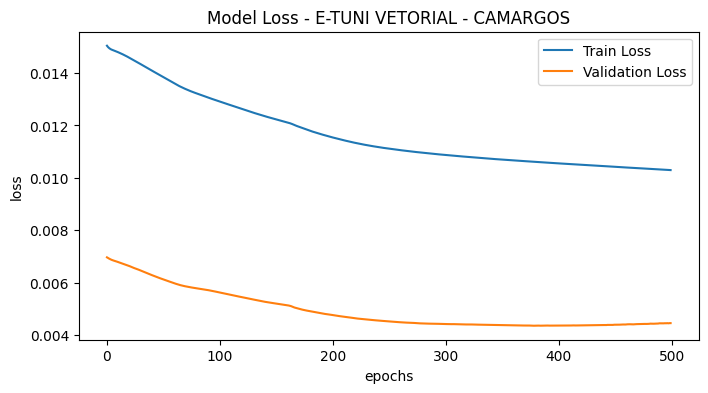

In [25]:


# Plot and save loss function from model history

method_name = 'E-TUNI VETORIAL - CAMARGOS'
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss - {method_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(f'{FIGURE_PATH}/model_loss_{method_name}.png', format='png')
plt.show()


In [26]:


model_vec_camargos_final = model_vec
# model_vec_camargos_final = EtuniModel(look_back=12, vec_num=12)
# model_vec_camargos_final.load_weights(file_path)

In [27]:
dataset_compilation = vec_camargos[lag_list].copy()
dataset_compilation[pred_list]= vec_camargos[pred_list]
df_result_vec_real = decode_etuni_vetorial(dataset_compilation,look_back,vec_num,deltaT)


dataset_compilation = vec_camargos[lag_list].copy()
dataset_compilation[pred_list] = model_vec_camargos_final.predict(vec_camargos[lag_list])
df_result_vec_pred = decode_etuni_vetorial(dataset_compilation,look_back,vec_num,deltaT)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [28]:
df_vec = vec_camargos[['date','start_date','end_date','cohort']].copy()
df_vec[pred_list] = df_result_vec_real[pred_list]
df_vec.columns = [x.replace('lag_etuni_','real_') for x in df_vec.columns]
df_vec[pred_list] = df_result_vec_pred[pred_list]
df_vec.columns = [x.replace('lag_etuni_','pred_') for x in df_vec.columns]
df_vec.to_csv('../Results/E-TUNI/Camargos/Vetorial/etuni_camargos_pred_2025_10_16.csv', index=False)

df_vec.head(5)


,date,start_date,end_date,cohort,real_12,real_11,real_10,real_9,real_8,real_7,real_6,real_5,real_4,real_3,real_2,real_1,pred_12,pred_11,pred_10,pred_9,pred_8,pred_7,pred_6,pred_5,pred_4,pred_3,pred_2,pred_1
0,1931-01-01,1932-01-01,1932-12-01,1. train,0.765683,0.571956,0.332103,0.070111,0.062731,0.118081,0.086716,0.068266,0.071956,0.107011,0.125461,0.380074,0.482464,0.460581,0.331058,0.373832,0.308791,0.322048,0.282536,0.295362,0.288670,0.356053,0.426098,0.655116
1,1931-02-01,1932-02-01,1933-01-01,1. train,0.571956,0.332103,0.070111,0.062731,0.118081,0.086716,0.068266,0.071956,0.107011,0.125461,0.380074,0.466790,0.622823,0.500484,0.383031,0.291932,0.275042,0.220104,0.205498,0.148523,0.204680,0.345049,0.510335,0.480004
2,1931-03-01,1932-03-01,1933-02-01,1. train,0.332103,0.070111,0.062731,0.118081,0.086716,0.068266,0.071956,0.107011,0.125461,0.380074,0.466790,0.234317,0.346646,0.222029,0.183323,0.061885,0.083441,0.034456,0.024016,-0.006235,0.062264,0.185370,0.301749,0.166555
3,1931-04-01,1932-04-01,1933-03-01,1. train,0.070111,0.062731,0.118081,0.086716,0.068266,0.071956,0.107011,0.125461,0.380074,0.466790,0.234317,0.208487,0.212461,0.148833,0.184629,0.091583,0.094862,0.099384,0.086587,0.193831,0.270591,0.346932,0.332571,0.262439
4,1931-05-01,1932-05-01,1933-04-01,1. train,0.062731,0.118081,0.086716,0.068266,0.071956,0.107011,0.125461,0.380074,0.466790,0.234317,0.208487,0.136531,0.021306,0.021277,-0.037305,-0.025665,-0.028415,0.073836,0.193222,0.320496,0.343834,0.345533,0.256484,0.213146


In [29]:
all_list = []
for i in range(1,12 + 1):
    column_real = f'real_{str(i)}'
    column_pred = f'pred_{str(i)}'
    df_temp = df_vec[['end_date',column_real,column_pred]].copy()
    df_temp.columns = ['date','real_norm','pred_norm']
    df_temp['date'] = (df_temp['date'] - pd.Timedelta(weeks=4*(i-1))).dt.strftime('%Y-%m-01')
    df_temp['real'] = camargos_scaler.inverse_transform(df_temp[['real_norm']])
    df_temp['pred'] = camargos_scaler.inverse_transform(df_temp[['pred_norm']])
    df_temp['index'] = df_temp.index

    all_list.append(df_temp)

all_list = pd.concat(all_list,axis=0,ignore_index=True)
all_list['date'] = pd.to_datetime(all_list['date'])
all_list['cohort'] = all_list['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))


all_list.to_csv('../Results/E-TUNI/Camargos/Vetorial/etuni_camargos_pred_all_2025_10_16.csv', index=False)

In [30]:
mean_precition = all_list.groupby('date').agg({'real':'mean','pred':['mean','std','min','max','count']})
mean_precition.reset_index(inplace=True)
mean_precition.columns = ['date','real','mean','std','min','max','count']
mean_precition['date'] = pd.to_datetime(mean_precition['date'])
mean_precition['cohort'] = mean_precition['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))
mean_precition.to_csv('../Results/E-TUNI/Camargos/Vetorial/etuni_camargos_pred_all_mean_2025_10_16.csv', index=False)

mean_precition.head(15)

,date,real,mean,std,min,max,count,cohort
0,1932-01-01,449.0,295.495647,NaN,295.495647,295.495647,1,1. train
1,1932-02-01,344.0,327.602425,62.179844,283.634636,371.570214,2,1. train
2,1932-03-01,214.0,246.859174,50.754533,213.433407,305.262119,3,1. train
3,1932-04-01,72.0,195.428203,50.524467,149.153727,241.602669,4,1. train
4,1932-05-01,68.0,137.433661,63.378680,45.547691,201.364649,5,1. train
5,1932-06-01,98.0,114.354825,71.273303,45.532101,208.549894,6,1. train
6,1932-07-01,81.0,94.503007,58.550547,13.780588,187.134276,7,1. train
7,1932-08-01,71.0,89.590710,57.221926,20.089353,194.086321,8,1. train
8,1932-09-01,73.0,90.057253,48.886101,18.599244,190.459229,9,1. train
9,1932-10-01,92.0,115.320014,54.356061,30.620560,226.980572,10,1. train


In [31]:
# train = df_vec[df_vec.cohort == '1. train']
# validation = df_vec[df_vec.cohort == '2. validation']
# test = df_vec[df_vec.cohort == '3. test']

train = mean_precition[mean_precition.cohort == '1. train']
validation = mean_precition[mean_precition.cohort == '2. validation']
test = mean_precition[mean_precition.cohort == '3. test']


In [32]:


metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Validation','Teste'],
      'MSE': [MSE(train['real'],train['mean']), MSE(validation['real'],validation['mean']), MSE(test['real'],test['mean'])],
      'MAE': [MAE(train['real'],train['mean']), MAE(validation['real'],validation['mean']), MAE(test['real'],test['mean'])],
      'MAPE': [MAPE(train['real'],train['mean']), MAPE(validation['real'],validation['mean']), MAPE(test['real'],test['mean'])],
      'R2':  [R2(train['real'],train['mean']), R2(validation['real'],validation['mean']), R2(test['real'],test['mean'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('../Results/E-TUNI/Camargos/Vetorial/etuni_camargos_metrics_2025_10_16.csv' , index=False)

,tipo,MSE,MAE,MAPE,R2
0,Treino,2705.315225,33.017253,0.254311,0.622694
1,Validation,1566.646718,28.394297,0.288752,0.568851
2,Teste,2833.719812,35.668490,0.287722,0.589647


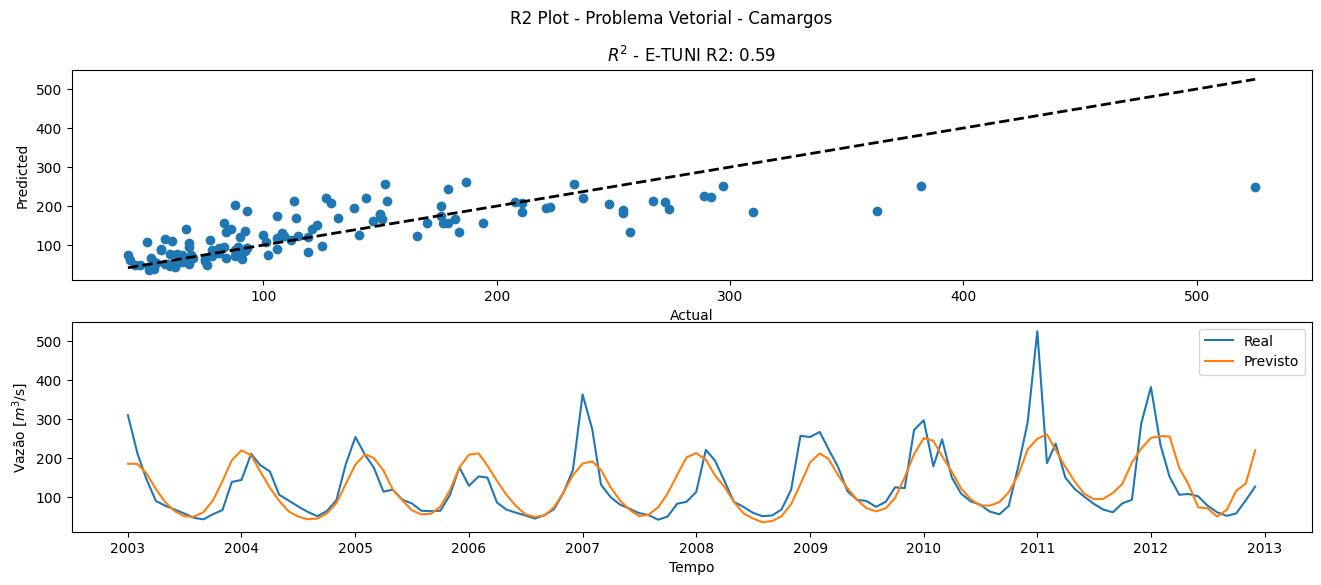

In [33]:
figure, axes = plt.subplots(2, 1, figsize=(16,6))
figure.suptitle(f'R2 Plot - Problema Vetorial - Camargos')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]
min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - E-TUNI R2: {r2_result:.2f}') #r2_result:.3f}')
# axes[0].scatter(test['real'], test['mean'])
axes[0].scatter(test['real'], test['mean'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=test,x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=test,x='date',y='mean', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'../Figure/Results/etuni_vec_camargos_r2_2025_10_16.png', format='png')


plt.show()

In [34]:
sample = 100

metrics_list = []
for s in range(sample):
    model_temp = EtuniModel(look_back=12,vec_num=12)

    # file_path = f"../Results/Models/camargos_vec_weights_narmax_sample_{i}.weights.h5"

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=file_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0
    )

    model_temp.fit(
        vec_train[lag_list],
        vec_train[pred_list],
        epochs=600,
        # batch_size=batch_size,
        batch_size=len(vec_train),
        verbose=0,
        validation_data=(vec_validation[lag_list], vec_validation[pred_list]),
        # callbacks=[model_checkpoint],
        shuffle=True
    )

    model_vec_camargos = model_temp
    # model_vec_camargos = NarmaxModel(look_back=12, vec_num=12)
    # model_vec_camargos.load_weights(file_path)
    camargos_scaler = joblib.load('../Results/Models/Camargos_scaler.pkl')

    dataset_compilation = vec_camargos[lag_list].copy()
    dataset_compilation[pred_list]= vec_camargos[pred_list]
    df_result_vec_real = decode_etuni_vetorial(dataset_compilation,look_back,vec_num,deltaT)


    dataset_compilation = vec_camargos[lag_list].copy()
    dataset_compilation[pred_list] = model_temp.predict(vec_camargos[lag_list])
    df_result_vec_pred = decode_etuni_vetorial(dataset_compilation,look_back,vec_num,deltaT)

    df_vec = vec_camargos[['date','start_date','end_date','cohort']].copy()
    df_vec[pred_list] = df_result_vec_real[pred_list]
    df_vec.columns = [x.replace('lag_etuni_','real_') for x in df_vec.columns]
    df_vec[pred_list] = df_result_vec_pred[pred_list]
    df_vec.columns = [x.replace('lag_etuni_','pred_') for x in df_vec.columns]
    df_vec['sample'] = s

    print(s)
    df_vec.to_csv(f'../Results/E-TUNI/Camargos/Vetorial/Samples/etuni_camargos_pred_sample_{s}.csv', index=False)



    all_list = []
    for i in range(1,12 + 1):
        column_real = f'real_{str(i)}'
        column_pred = f'pred_{str(i)}'
        df_temp = df_vec[['end_date',column_real,column_pred]].copy()
        df_temp.columns = ['date','real_norm','pred_norm']
        df_temp['date'] = (df_temp['date'] - pd.Timedelta(weeks=4*(i-1))).dt.strftime('%Y-%m-01')
        df_temp['real'] = camargos_scaler.inverse_transform(df_temp[['real_norm']])
        df_temp['pred'] = camargos_scaler.inverse_transform(df_temp[['pred_norm']])
        df_temp['index'] = df_temp.index

        all_list.append(df_temp)

    all_list = pd.concat(all_list,axis=0,ignore_index=True)
    all_list['date'] = pd.to_datetime(all_list['date'])
    all_list['cohort'] = all_list['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))
    all_list['sample'] = s

    all_list.to_csv(f'../Results/E-TUNI/Camargos/Vetorial/Samples/etuni_camargos_pred_all_sample_{s}.csv', index=False)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
0
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
12
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
14
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
17
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
18
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
22
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23
31

In [36]:
all_results = pd.concat([model_performance_vec(pd.read_csv(f'../Results/E-TUNI/Camargos/Vetorial/Samples/etuni_camargos_pred_all_sample_{i}.csv')) for i in range(sample)]).reset_index(drop=True)
all_results.to_csv(f'../Results/E-TUNI/Camargos/Vetorial/Samples/all_results.csv', index=False)
all_results



,sample,tipo,MSE,MAE,MAPE,R2
0,0.0,Treino,2678.449656,32.874090,0.248581,0.626441
1,0.0,Validation,1714.481608,29.469839,0.291040,0.528166
2,0.0,Teste,3011.777713,35.793408,0.284164,0.563862
3,1.0,Treino,2696.488076,33.837726,0.260778,0.623925
4,1.0,Validation,1247.747183,25.928922,0.268320,0.656614
...,...,...,...,...,...,...
295,98.0,Validation,1455.247100,26.170032,0.262687,0.599509
296,98.0,Teste,2896.821330,34.027646,0.262959,0.580509
297,99.0,Treino,2501.690994,31.762029,0.237178,0.651093
298,99.0,Validation,1520.744208,27.192827,0.266079,0.581484


# Furnas

In [ ]:
furnas_raw = pd.read_csv(f'../Datasets/Processed/Furnas.csv')
esc_furnas = escalar_etuni_build(furnas_raw,look_back,deltaT)
vec_furnas = vetorial_etuni_build(furnas_raw,look_back,vec_num,deltaT)


In [ ]:
esc_furnas.cohort.value_counts()

In [ ]:
vec_furnas.cohort.value_counts()

In [ ]:
vec_furnas[[x for x in vec_furnas.columns if 'lag_etuni' not in x]]

In [ ]:
esc_furnas.groupby('cohort').agg(
    {'date':['min','max','count']
    }
)


In [ ]:
vec_furnas.groupby('cohort').agg(
    {'start_date':['min','max','count'],
     'end_date':['min','max','count']
    }
)


## Escalar 

In [ ]:
esc_furnas.head()

In [ ]:
lag_list = [x for x in esc_furnas.columns if 'lag_etuni' in x]
pred_list = lag_list.pop()

In [ ]:
esc_train = esc_furnas[esc_furnas['cohort'] == '1. train'].copy()
esc_validation = esc_furnas[esc_furnas['cohort'] == '2. validation'].copy()
esc_test = esc_furnas[esc_furnas['cohort'] == '3. test'].copy()

In [ ]:
file_path = "../Results/Models/furnas_esc_weights_etuni_img.weights.h5"

# Definindo os callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    save_weights_only=True,
    # monitor='val_loss',
    # mode='min',
    monitor='val_r2',
    mode='max',
    save_best_only=True,
    verbose=0
)


In [ ]:
model_esc = EtuniModel(look_back=12,vec_num=1)

callbacks_list = [
    model_checkpoint
    ]

history = model_esc.fit(
    esc_train[lag_list],
    esc_train[pred_list],
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(esc_validation[lag_list], esc_validation[pred_list]),
    # callbacks=callbacks_list,
    shuffle=True
)


In [ ]:
# Plot and save loss function from model history

method_name = 'E-TUNI ESCALAR - FURNAS'
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss - {method_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(f'{FIGURE_PATH}/model_loss_{method_name}.png', format='png')
plt.show()



In [ ]:
# model_esc_furnas = EtuniModel(look_back=12, vec_num=1)
# model_esc_furnas.load_weights(file_path)
model_esc_furnas = model_esc

furnas_scaler = joblib.load('../Results/Models/Furnas_scaler.pkl')
df_escalar = esc_furnas[['date','pred_1']].copy()
df_escalar.columns = ['date','real_norm']
df_escalar['real'] = furnas_scaler.inverse_transform(df_escalar[['real_norm']])

dataset_compilation = esc_furnas[lag_list].copy()
dataset_compilation[pred_list] = model_esc.predict(esc_furnas[lag_list])

df_result_esc = decode_etuni_escalar(dataset_compilation,look_back,deltaT)
df_escalar['pred_norm'] = df_result_esc[pred_list]
df_escalar['pred'] = furnas_scaler.inverse_transform(df_escalar[['pred_norm']])

df_escalar['tipo'] = df_escalar['date'].apply(lambda x: cohort_type(x,model_type='escalar'))

df_escalar.to_csv('../Results/E-TUNI/Furnas/Escalar/etuni_furnas_pred_2025_11_03.csv', index=False)

df_escalar


In [ ]:
train = df_escalar[df_escalar.tipo == '1. train']
validation = df_escalar[df_escalar.tipo == '2. validation']
test = df_escalar[df_escalar.tipo == '3. test']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Validation','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(validation['real'],validation['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(validation['real'],validation['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(validation['real'],validation['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(validation['real'],validation['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('../Results/E-TUNI/Furnas/Escalar/etuni_furnas_results_2025_11_03.csv' , index=False)

In [ ]:
figure, axes = plt.subplots(2, 1, figsize=(16,6))
figure.suptitle(f'R2 Plot - Problema Escalar - Furnas')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - E-TUNI R2: {r2_result:.2f}') #r2_result:.3f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Real')
axes[0].set_ylabel('Previsto')

sns.lineplot(ax = axes[1], data=test,x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=test,x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'../Figure/Results/etuni_esc_furnas_r2_2025_10_15.png', format='png')

plt.show()

In [ ]:
sample = 100

metrics_list = []
for i in range(sample):
    model_temp = EtuniModel(look_back=12,vec_num=1)

    file_path = f"../Results/Models/furnas_esc_weights_etuni_sample_{i}.weights.h5"

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=file_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0
    )

    # model_temp.fit(
    #     esc_train[lag_list],
    #     esc_train[pred_list],
    #     epochs=650,
    #     batch_size=batch_size,
    #     verbose=0,
    #     validation_data=(esc_validation[lag_list], esc_validation[pred_list]),
    #     # callbacks=[model_checkpoint],
    #     shuffle=True
    # )

    model_temp.fit(
        esc_train[lag_list],
        esc_train[pred_list],
        epochs=epochs//2,
        # batch_size=batch_size,
        batch_size=len(esc_train),
        verbose=0,
        validation_data=(esc_validation[lag_list], esc_validation[pred_list]),
        # callbacks=[model_checkpoint],
        shuffle=True
    )

    model_esc_furnas = model_temp
    furnas_scaler = joblib.load('../Results/Models/Furnas_scaler.pkl')
    df_escalar = esc_furnas[['date','pred_1']].copy()
    df_escalar.columns = ['date','real_norm']
    df_escalar['real'] = furnas_scaler.inverse_transform(df_escalar[['real_norm']])
    
    dataset_compilation = esc_furnas[lag_list].copy()
    dataset_compilation[pred_list] = model_esc_furnas.predict(esc_furnas[lag_list])
    df_result_esc = decode_etuni_escalar(dataset_compilation,look_back,deltaT)
    df_escalar['pred_norm'] = df_result_esc[pred_list]
    df_escalar['pred'] = furnas_scaler.inverse_transform(df_escalar[['pred_norm']])
    df_escalar['tipo'] = df_escalar['date'].apply(lambda x: cohort_type(x,model_type='escalar'))
    df_escalar['sample'] = i
    print(i)

    del model_temp

    df_escalar.to_csv(f'../Results/E-TUNI/Furnas/Escalar/Samples/etuni_furnas_pred_sample_{i}.csv', index=False)





In [ ]:
def model_performance(df_predicted):
    train = df_predicted[df_predicted.tipo == '1. train']
    validation = df_predicted[df_predicted.tipo == '2. validation']
    test = df_predicted[df_predicted.tipo == '3. test']

    metric_df_final = pd.DataFrame(
        {
        'sample': df_predicted['sample'].unique()[0],
        'tipo':['Treino','Validation','Teste'],
        'MSE': [MSE(train['real'],train['pred']), MSE(validation['real'],validation['pred']), MSE(test['real'],test['pred'])],
        'MAE': [MAE(train['real'],train['pred']), MAE(validation['real'],validation['pred']), MAE(test['real'],test['pred'])],
        'MAPE': [MAPE(train['real'],train['pred']), MAPE(validation['real'],validation['pred']), MAPE(test['real'],test['pred'])],
        'R2':  [R2(train['real'],train['pred']), R2(validation['real'],validation['pred']), R2(test['real'],test['pred'])],
        }
    )

    return metric_df_final



In [ ]:
all_results = pd.concat([model_performance(pd.read_csv(f'../Results/E-TUNI/Furnas/Escalar/Samples/etuni_furnas_pred_sample_{i}.csv')) for i in range(sample)]).reset_index(drop=True)
all_results.to_csv(f'../Results/E-TUNI/Furnas/Escalar/Samples/all_results_escalar.csv', index=False)
all_results

## Vetorial

In [ ]:
all_list = [x for x in vec_furnas.columns if 'lag_etuni_' in x]

lag_list = []
pred_list = []

for col in all_list:
    num = int(col.split('lag_etuni_')[1])
    if num > 12:
        lag_list.append(col)
    else:
        pred_list.append(col)

len(all_list)

In [ ]:
vec_train = vec_furnas[vec_furnas['cohort'] == '1. train'].copy()
vec_validation = vec_furnas[vec_furnas['cohort'] == '2. validation'].copy()
vec_test = vec_furnas[vec_furnas['cohort'] == '3. test'].copy()

In [ ]:
print(vec_train.shape)
print(vec_validation.shape)
print(vec_test.shape)


In [ ]:
model_vec = EtuniModel(look_back=12,vec_num=12)
file_path = f"../Results/Models/furnas_vec_weights_etuni_img.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    save_weights_only=True,
    # monitor='val_loss',
    # mode='min',
    monitor='val_r2',
    mode='max',
    save_best_only=True,
    verbose=0
)

history = model_vec.fit(
    vec_train[lag_list],
    vec_train[pred_list],
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(vec_validation[lag_list], vec_validation[pred_list]),
    # callbacks=[model_checkpoint],
    shuffle=True
)

In [ ]:
# Plot and save loss function from model history

method_name = 'E-TUNI VETORIAL - FURNAS'
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss - {method_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(f'{FIGURE_PATH}/model_loss_{method_name}.png', format='png')
plt.show()


In [ ]:
model_vec_furnas_final = model_vec


In [ ]:
dataset_compilation = vec_furnas[lag_list].copy()
dataset_compilation[pred_list]= vec_furnas[pred_list]
df_result_vec_real = decode_etuni_vetorial(dataset_compilation,look_back,vec_num,deltaT)


dataset_compilation = vec_furnas[lag_list].copy()
dataset_compilation[pred_list] = model_vec_furnas_final.predict(vec_furnas[lag_list])
df_result_vec_pred = decode_etuni_vetorial(dataset_compilation,look_back,vec_num,deltaT)

In [ ]:
df_vec = vec_furnas[['date','start_date','end_date','cohort']].copy()
df_vec[pred_list] = df_result_vec_real[pred_list]
df_vec.columns = [x.replace('lag_etuni_','real_') for x in df_vec.columns]
df_vec[pred_list] = df_result_vec_pred[pred_list]
df_vec.columns = [x.replace('lag_etuni_','pred_') for x in df_vec.columns]
df_vec.to_csv('../Results/E-TUNI/Furnas/Vetorial/etuni_furnas_pred_2025_10_16.csv', index=False)

df_vec.head(5)


In [ ]:
all_list = []
for i in range(1,12 + 1):
    column_real = f'real_{str(i)}'
    column_pred = f'pred_{str(i)}'
    df_temp = df_vec[['end_date',column_real,column_pred]].copy()
    df_temp.columns = ['date','real_norm','pred_norm']
    df_temp['date'] = (df_temp['date'] - pd.Timedelta(weeks=4*(i-1))).dt.strftime('%Y-%m-01')
    df_temp['real'] = furnas_scaler.inverse_transform(df_temp[['real_norm']])
    df_temp['pred'] = furnas_scaler.inverse_transform(df_temp[['pred_norm']])
    df_temp['index'] = df_temp.index

    all_list.append(df_temp)

all_list = pd.concat(all_list,axis=0,ignore_index=True)
all_list['date'] = pd.to_datetime(all_list['date'])
all_list['cohort'] = all_list['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))


all_list.to_csv('../Results/E-TUNI/Furnas/Vetorial/etuni_furnas_pred_all_2025_10_16.csv', index=False)

In [ ]:
mean_precition = all_list.groupby('date').agg({'real':'mean','pred':['mean','std','min','max','count']})
mean_precition.reset_index(inplace=True)
mean_precition.columns = ['date','real','mean','std','min','max','count']
mean_precition['date'] = pd.to_datetime(mean_precition['date'])
mean_precition['cohort'] = mean_precition['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))
mean_precition.to_csv('../Results/E-TUNI/Furnas/Vetorial/etuni_furnas_pred_all_mean_2025_10_16.csv', index=False)

mean_precition.head(15)

In [ ]:
# train = df_vec[df_vec.cohort == '1. train']
# validation = df_vec[df_vec.cohort == '2. validation']
# test = df_vec[df_vec.cohort == '3. test']

train = mean_precition[mean_precition.cohort == '1. train']
validation = mean_precition[mean_precition.cohort == '2. validation']
test = mean_precition[mean_precition.cohort == '3. test']


In [ ]:


metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Validation','Teste'],
      'MSE': [MSE(train['real'],train['mean']), MSE(validation['real'],validation['mean']), MSE(test['real'],test['mean'])],
      'MAE': [MAE(train['real'],train['mean']), MAE(validation['real'],validation['mean']), MAE(test['real'],test['mean'])],
      'MAPE': [MAPE(train['real'],train['mean']), MAPE(validation['real'],validation['mean']), MAPE(test['real'],test['mean'])],
      'R2':  [R2(train['real'],train['mean']), R2(validation['real'],validation['mean']), R2(test['real'],test['mean'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('../Results/E-TUNI/Furnas/Vetorial/etuni_furnas_metrics_2025_10_16.csv' , index=False)

In [ ]:
figure, axes = plt.subplots(2, 1, figsize=(16,6))
figure.suptitle(f'R2 Plot - Problema Vetorial - Furnas')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]
min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - NARMAX R2: {r2_result:.2f}') #r2_result:.3f}')
# axes[0].scatter(test['real'], test['mean'])
axes[0].scatter(test['real'], test['mean'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=test,x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=test,x='date',y='mean', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'../Figure/Results/etuni_vec_furnas_r2_2025_10_16.png', format='png')


plt.show()

In [ ]:
sample = 100

metrics_list = []
for s in range(sample):
    model_temp = EtuniModel(look_back=12,vec_num=12)

    # file_path = f"../Results/Models/furnas_vec_weights_narmax_sample_{i}.weights.h5"

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=file_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0
    )

    model_temp.fit(
        vec_train[lag_list],
        vec_train[pred_list],
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        validation_data=(vec_validation[lag_list], vec_validation[pred_list]),
        # callbacks=[model_checkpoint],
        shuffle=True
    )

    model_vec_furnas = model_temp
    furnas_scaler = joblib.load('../Results/Models/Furnas_scaler.pkl')

    dataset_compilation = vec_furnas[lag_list].copy()
    dataset_compilation[pred_list]= vec_furnas[pred_list]
    df_result_vec_real = decode_etuni_vetorial(dataset_compilation,look_back,vec_num,deltaT)


    dataset_compilation = vec_furnas[lag_list].copy()
    dataset_compilation[pred_list] = model_vec_furnas.predict(vec_furnas[lag_list])
    df_result_vec_pred = decode_etuni_vetorial(dataset_compilation,look_back,vec_num,deltaT)

    df_vec = vec_furnas[['date','start_date','end_date','cohort']].copy()
    df_vec[pred_list] = df_result_vec_real[pred_list]
    df_vec.columns = [x.replace('lag_etuni_','real_') for x in df_vec.columns]
    df_vec[pred_list] = df_result_vec_pred[pred_list]
    df_vec.columns = [x.replace('lag_etuni_','pred_') for x in df_vec.columns]
    df_vec['sample'] = s

    print(s)
    df_vec.to_csv(f'../Results/E-TUNI/Furnas/Vetorial/Samples/etuni_furnas_pred_sample_{i}.csv', index=False)



    all_list = []
    for i in range(1,12 + 1):
        column_real = f'real_{str(i)}'
        column_pred = f'pred_{str(i)}'
        df_temp = df_vec[['end_date',column_real,column_pred]].copy()
        df_temp.columns = ['date','real_norm','pred_norm']
        df_temp['date'] = (df_temp['date'] - pd.Timedelta(weeks=4*(i-1))).dt.strftime('%Y-%m-01')
        df_temp['real'] = furnas_scaler.inverse_transform(df_temp[['real_norm']])
        df_temp['pred'] = furnas_scaler.inverse_transform(df_temp[['pred_norm']])
        df_temp['index'] = df_temp.index

        all_list.append(df_temp)

    all_list = pd.concat(all_list,axis=0,ignore_index=True)
    all_list['date'] = pd.to_datetime(all_list['date'])
    all_list['cohort'] = all_list['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))
    all_list['sample'] = s

    all_list.to_csv(f'../Results/E-TUNI/Furnas/Vetorial/Samples/etuni_furnas_pred_all_sample_{s}.csv', index=False)

In [ ]:
all_results = pd.concat([model_performance_vec(pd.read_csv(f'../Results/E-TUNI/Furnas/Vetorial/Samples/etuni_furnas_pred_all_sample_{i}.csv')) for i in range(sample)]).reset_index(drop=True)
all_results.to_csv(f'../Results/E-TUNI/Furnas/Vetorial/Samples/all_results.csv', index=False)
all_results

